# Generative Adversarial Network in Tensorflow

**Generative Adversarial Networks**, introduced by Ian Goodfellow in 2014, are neural nets we can train to _produce_ new images (or other kinds of data) that look as though they came from our true data distribution. In this notebook, we'll implement a small GAN for generating images that look as though they come from the MNIST dataset.

The key insight behind the GAN is to pit two neural networks against each other. On the one hand is the **Generator**, a neural network that takes random noise as input and produces an image as output. On the other hand is the **Discriminator**, which takes in an image and classifies it as real (from MNIST) or fake (from our Generator). During training, we alternate between training the Generator to fool the Discriminator, and training the Discriminator to call the Generator's bluff.

Implementing a GAN in Tensorflow will give you practice turning more involved models into working code, and is also a good showcase for the Keras `Model` abstraction.

## Imports

In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [0]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

## Loading the data

As in previous examples, we'll use MNIST, because it's a small and easy-to-use dataset that comes bundled with Tensorflow.

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Utility functions

We first provide a simple function for displaying a few 28-by-28-pixel images. This will help us understand the progress of our GAN as it trains; we'll use it to visualize the generated 'fake digit' images.

In [0]:
def visualize_row(images, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.show()

## Hyperparameters

Let's now set some hyperparameters, for use later on.

In [0]:
# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784
# Training parameters
batch_size = 50
iterations = 25000

## Generator

A GAN is made up of two smaller networks: a generator and a discriminator. The generator is responsible for sampling images from a distribution that we hope will get closer and closer, as we train, to the real data distribution.

Neural networks are deterministic, so in order to sample a new image from the generator, we first create some random noise `z` (in our case, `z` will be a 32-dimensional uniform random variable) and then feed that noise to the network. You can think of `z` as being a latent, low-dimensional representation of some image `G(z)`, though in a vanilla GAN, it is usually difficult to interpret `z`'s components in a meaningful way.

Our generator is a dead-simple multi-layer perceptron (feed-forward network), with 128 hidden units. We use sigmoid activation at the end, to make sure our output pixels are each in the range `[0, 1]` (with 0 as black, and 1 as white).

What is new is that here we are using Keras's `Model` abstraction. We are going to write a function `make_generator`, which creates all the relevant weight variables for the generator and adds them to the graph. Then we are going to return a _Model_, `G`, that behaves like a "graph constructor." A user can call `G(z)` with some tensor `z`, and it will add nodes to the graph for computing the fake image from the random noise `z`. Those nodes will do things like matrix multiplies and `relu`s, using the weights that were created when we called `make_generator`. This allows us to _reuse_ `G` with multiple inputs, such that each use of `G` uses the same underlying weights. The Keras `Model` object `G` also has useful properties that we'll need later on -- for example, `G.trainable_variables` gives us access to all the weight variables that were created by `make_generator`.

In [0]:
# Keras generator
def make_generator():
    # This "z_in" is a 'symbolic input node' -- do not think of it as belonging to the graph yet.
    z_in = tf.keras.layers.Input((z_dimension,))
    # This call to `Dense` adds weights and biases to the graph, but does not conceptually add
    # matrix multiplication and ReLU yet; that will happen when the generator is applied to an 
    # actual input tensor later.
    hidden_layer = tf.keras.layers.Dense(intermediate_layer_size, activation='relu')(z_in)
    # Similarly, this `Dense` just serves to add more weights and biases to the graph
    fake_X = tf.keras.layers.Dense(image_size, activation='sigmoid')(hidden_layer)
    # The thing we will return is a `Model`. We specify the input and output nodes of 
    # the generator, and the Model acts as a kind of "reusable template" -- when applied to
    # different input tensors, it will construct the appropriate matrix multiply and ReLU
    # and sigmoid operations for producing `fake_X`.
    G = tf.keras.Model(inputs=[z_in], outputs=[fake_X])
    return G

## Discriminator

Although it isn't necesssary, it makes some sense for our discriminator to mirror the generator's architecture, as we do here. The discriminator takes in an image (perhaps a real one from the MNIST dataset, perhaps a fake one from our generator), and attempts to classify it as real (1) or fake (0). Our architecture is again a simple MLP, taking 784 pixels down to 128 hidden units, and finally down to a probability.

In [0]:
def make_discriminator():
    images_in = tf.keras.layers.Input((image_size,))
    hidden_layer = tf.keras.layers.Dense(intermediate_layer_size, activation='relu')(images_in)
    D_output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)
    D = tf.keras.Model(inputs=[images_in], outputs=[D_output])
    return D

## Building the graph

Given a generator and discriminator, we can now set up the GAN's computational graph. 

In [0]:
tf.reset_default_graph()

# We begin by creating placeholders for the real images and noise, z.
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

# We create both the generator and discriminator. This adds weights to 
# the graph, and returns Model objects D and G that we can apply to 
# actual tensors.
D = make_discriminator()
G = make_generator()

# Apply the generator to z.
fake_X = G(z)

# Apply the discriminator to the fake images and the real images
d_on_fake = D(fake_X)
d_on_real = D(real_X)

# Compute the losses
g_loss = -tf.reduce_mean(tf.log(d_on_fake + 1e-20))
d_loss = -tf.reduce_mean(tf.log(d_on_real + 1e-20) + tf.log(1. - d_on_fake + 1e-20))

# Create the two optimization operations
optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=D.trainable_variables)
optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=G.trainable_variables)

# Create the operation that initializes the variables.
initialize_all = tf.global_variables_initializer()

## Training a GAN

Our training procedure is a bit more involved than in past demos. Here are the main differences:
1. Each iteration, we first train the generator, then (separately) the discriminator.
2. Each iteration, we need to feed in a batch of images, just as in previous notebooks. But we also need a batch of noise samples. For this, we use Numpy's `np.random.uniform` function.
3. Every 1000 iterations, we log some data to the console and visualize a few samples from our generator.

Iter [       0] Time [0.1720] d_loss [1.5348]


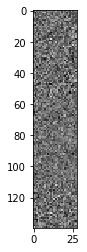

Iter [    1000] Time [3.2172] d_loss [0.0072]


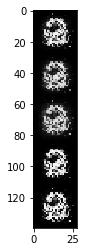

Iter [    2000] Time [6.1019] d_loss [0.0323]


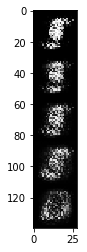

Iter [    3000] Time [8.9982] d_loss [0.1342]


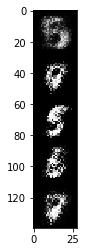

Iter [    4000] Time [11.8893] d_loss [0.0709]


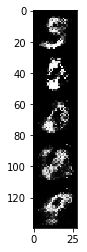

Iter [    5000] Time [14.7946] d_loss [0.2432]


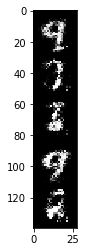

Iter [    6000] Time [17.5840] d_loss [0.4204]


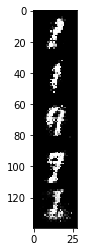

Iter [    7000] Time [20.4612] d_loss [0.3936]


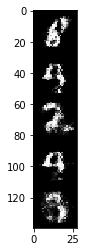

Iter [    8000] Time [23.3601] d_loss [0.4631]


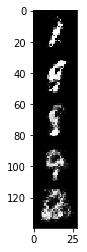

Iter [    9000] Time [26.2560] d_loss [0.5352]


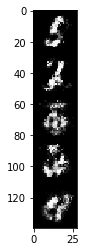

Iter [   10000] Time [29.1720] d_loss [0.7228]


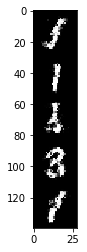

Iter [   11000] Time [32.0881] d_loss [0.6075]


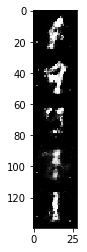

Iter [   12000] Time [34.9278] d_loss [0.8416]


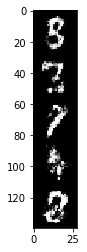

Iter [   13000] Time [37.8152] d_loss [0.9661]


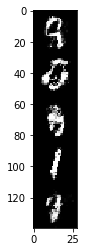

Iter [   14000] Time [40.7062] d_loss [0.8773]


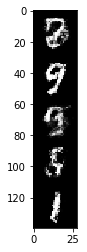

Iter [   15000] Time [43.6029] d_loss [0.7014]


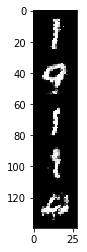

Iter [   16000] Time [46.4908] d_loss [0.6759]


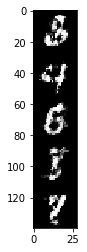

Iter [   17000] Time [49.2651] d_loss [0.9014]


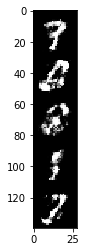

Iter [   18000] Time [52.1368] d_loss [0.6798]


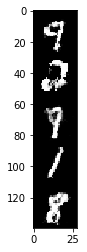

Iter [   19000] Time [55.0235] d_loss [0.7929]


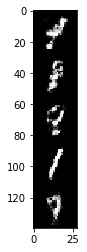

Iter [   20000] Time [57.9002] d_loss [0.5453]


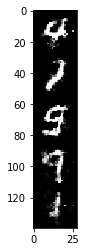

Iter [   21000] Time [60.7742] d_loss [0.7778]


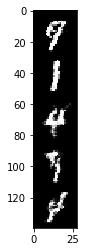

Iter [   22000] Time [63.6598] d_loss [0.7754]


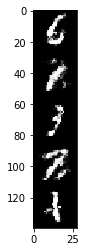

Iter [   23000] Time [66.4623] d_loss [0.7243]


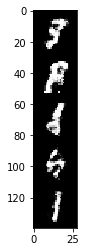

Iter [   24000] Time [69.3442] d_loss [0.8816]


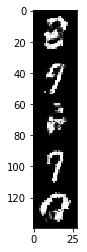

Iter [   24999] Time [72.3101] d_loss [0.8635]


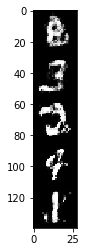

In [18]:
# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(optimize_g, feed_dict=next_feed_dict())
    _, loss = sess.run([optimize_d, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:5])

# Extensions: Playing with GANs

### Interpolating between images

As our “random noise” varies, so does the image our GAN generates. Perturbing the random input a little bit should perturb the image a little bit. This means that by taking small steps from one input to another, we can “animate” the transition from the image our GAN draws for the first to the one it draws for the second. Generate two random samples from a GAN, and interpolate between them (with, say, 100 steps).

In particular:
1. Train a GAN (using code from class).
2. Generate some noise `= np.random.uniform(-1, 1, [10, 32])` (for instance).
3. Get some fake images out using `sess.run(fake_X, {z: noise})`
4. Visualize them using `visualize_row()` and choose two images you like (say, image 1 and 3). Pull out `start` and `end` noise vectors (e.g., `start = noise[0]` and `end = noise[2]`).
5. Generate a list of ten vectors `steps = [..., ..., ...]`, where entry `i` is `i*10`% of the way from start to end.
6. `np.concatenate(steps)` (with appropriate axis) to get a new noise matrix. Run the GAN on that noise matrix, and visualize the 10 images you get as results.

In [0]:
### YOUR CODE HERE











### Conditioning on the class label

In class, we drew a random noise vector $z$, and passed it into the Generator. This gave us very little control over the images we generated. Suppose we wanted to be able to generate a random image of a two, or of a three. In other words, we want to train the model to know how to draw whatever digit we tell it to. How could you alter the training procedure to make this work? Implement a conditional GAN, and use it to generate twos or threes.

In particular,

1. Modify the code from class to take placeholder inputs (real images and z values) that are 10 elements longer.
2. Modify the next_feed_dict to concatenate labels (one-hot, ten-dimensional) to the noise inputs and image inputs.
3. Train the GAN.
4. Try making the GAN generate a few ones, then a few threes, by concatenating `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]` or `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`, say, to your noise vectors. How does it do?

In [0]:
### YOUR CODE HERE










